# Data Loading/Preprocessing/Visualization

### Loading

In [3]:
import json
import numpy as np

# Load the data from the JSON file
with open('data/data.json') as f:
    data = json.load(f)

# Print the data content of the JSON file
print(f"Data is list of {len(data)} items")
print(f"Each item is a dictionary with keys: {data[0].keys()}")
print(f"The 'sequence' key is a list of {np.array(data[0]['sequence']).shape[0]} elements with 15x15=225 entries each")
print(f"When an items has label '1', the sequence contain at least one elements which has quanching")
print(f"The events with label '1' have also wich step of the sequece has the 'quench' label where it's stored the x,y,t position of the quenching event and the temperature")


Data is list of 3000 items
Each item is a dictionary with keys: dict_keys(['sequence', 'label'])
The 'sequence' key is a list of 24 elements with 15x15=225 entries each
When an items has label '1', the sequence contain at least one elements which has quanching
The events with label '1' have also wich step of the sequece has the 'quench' label where it's stored the x,y,t position of the quenching event and the temperature


### Preprocessing for data visualization

In [4]:
# Let's convert the data to a numpy array
dataPost = np.array([[np.array(item['sequence'][step]).reshape(15, 15) for step in np.arange(0, 24) ] for item in data]) #looping over sequences and reshaping each step of the sequence to 15x15
labels = np.array([item['label'] for item in data]) #looping over sequences and getting the label of each sequence 

# -------- quench label --------
quench = [item["quench"] if item['label'] == 1 else [{'step': -1, 'pixel': [-1, -1], 'temp': -1}] for item in data]
maxNquenches = max([len(item) for item in quench])
print(f"Max number of quenching events in a sequence: {maxNquenches}")

for i in range(len(quench)):
    while len(quench[i]) < 24:
        quench[i].append({'step': -1, 'pixel': [-1, -1], 'temp': -1})
quench = np.array(quench)

# Now let's convert it in a numpy structured array
dtype = np.dtype([('step', 'i4'), ('pixel_x', 'i4'), ('pixel_y', 'i4'), ('temp', 'f4')])
quenchPost = np.zeros((quench.shape[0], quench.shape[1]), dtype=dtype)

for i in range(quench.shape[0]):
    for j in range(quench.shape[1]):
        quenchPost[i, j] = (
            quench[i][j]['step'],
            quench[i][j]['pixel'][0],
            quench[i][j]['pixel'][1],
            quench[i][j]['temp']
        )
# ------------------------------                       #All this work is to have a more defined structure of the data, so we can use it in the model later on


print(f"quenchPost shape: {quench.shape}") # --> (n_sequences, maxNquenches)
print(f"dataPost shape: {dataPost.shape}") # --> (n_sequences, n_steps, 15, 15)
print(f"labels shape: {labels.shape}") # --> (n_sequences,)

Max number of quenching events in a sequence: 14
quenchPost shape: (3000, 24)
dataPost shape: (3000, 24, 15, 15)
labels shape: (3000,)


### Visualization

In [5]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

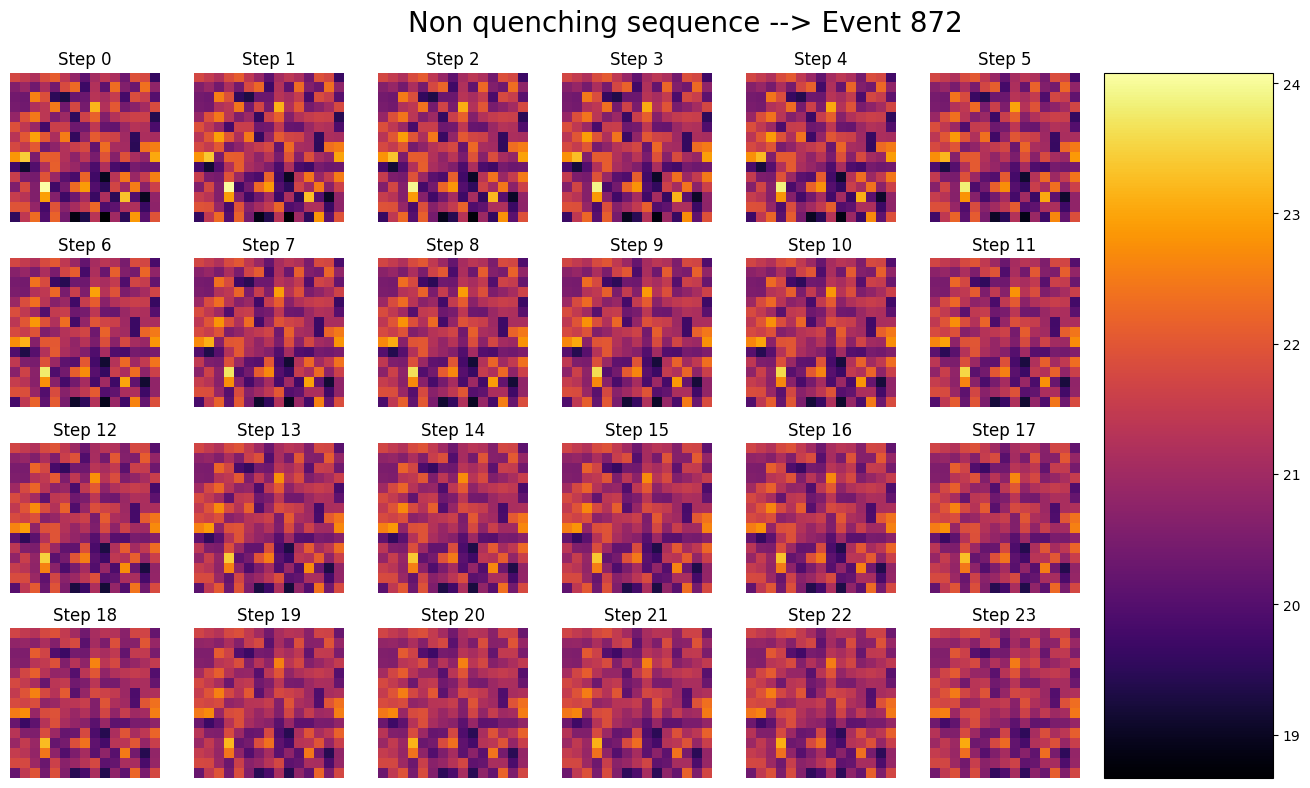

In [6]:
# -----------------Let's plot a non quenching sequence-------------------

idx = np.random.choice(np.where(labels == 0)[0])
vmin = dataPost[idx].min()
vmax = dataPost[idx].max()
fig = plt.figure(figsize=(14, 8))
gs = GridSpec(4, 7, figure=fig) 
axs = [fig.add_subplot(gs[i // 6, i % 6]) for i in range(24)]
for i, ax in enumerate(axs):
    im = ax.imshow(dataPost[idx, i], cmap='inferno', vmin=vmin, vmax=vmax)
    ax.axis('off')
    ax.set_title(f"Step {i}")
fig.suptitle(f"Non quenching sequence --> Event {idx}", fontsize= 20)
cax = fig.add_subplot(gs[:, -1])
fig.colorbar(im, cax=cax, orientation='vertical')
plt.tight_layout(rect=[0, 0, 0.95, 1])  # Aggiusta il layout per fare spazio alla colorbar
plt.show()



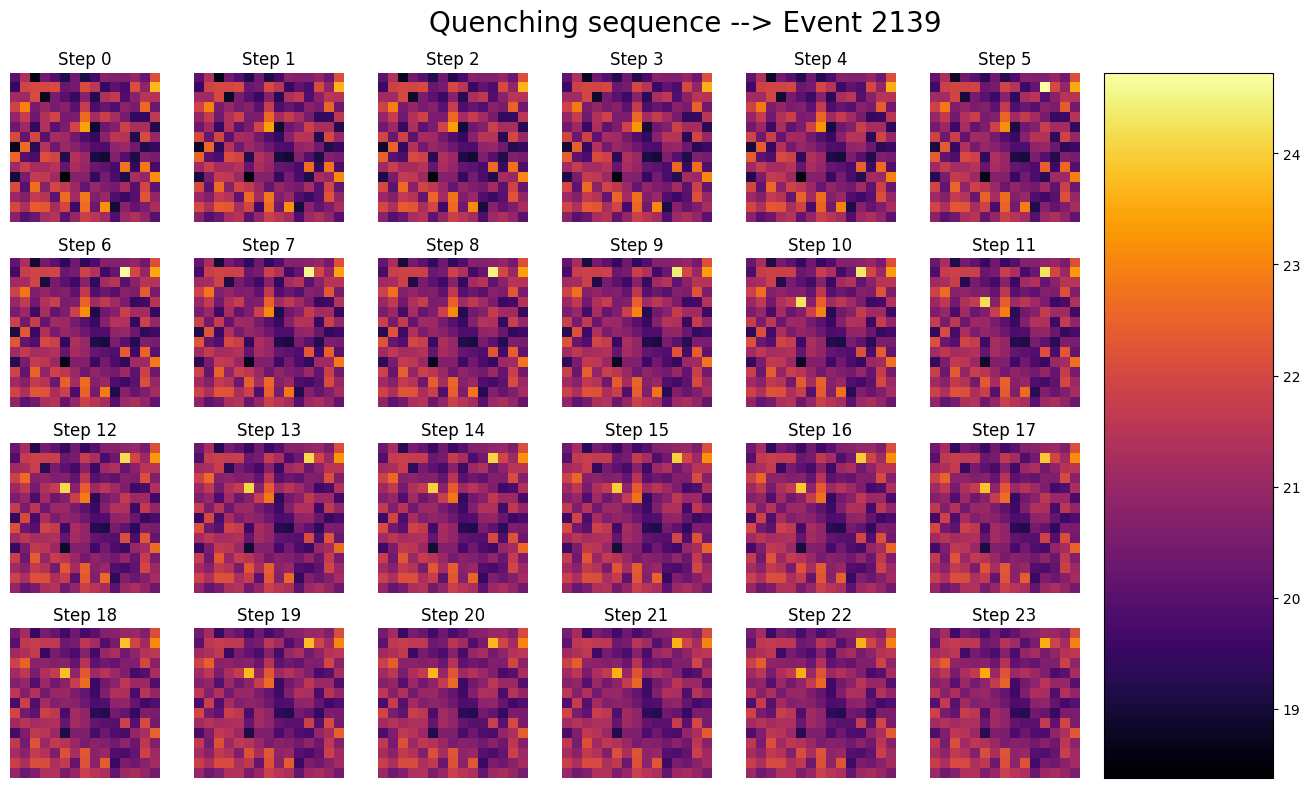

In [7]:
# -----------------Let's plot a quenching sequence-------------------

idx = np.random.choice(np.where(labels == 1)[0])
vmin = dataPost[idx].min()
vmax = dataPost[idx].max()
fig = plt.figure(figsize=(14, 8))
gs = GridSpec(4, 7, figure=fig) 
axs = [fig.add_subplot(gs[i // 6, i % 6]) for i in range(24)]
for i, ax in enumerate(axs):
    im = ax.imshow(dataPost[idx, i], cmap='inferno', vmin=vmin, vmax=vmax)
    ax.axis('off')
    ax.set_title(f"Step {i}")
fig.suptitle(f"Quenching sequence --> Event {idx}", fontsize= 20)
cax = fig.add_subplot(gs[:, -1])
fig.colorbar(im, cax=cax, orientation='vertical')
plt.tight_layout(rect=[0, 0, 0.95, 1])  # Aggiusta il layout per fare spazio alla colorbar
plt.show()


In [8]:
#This is the data we will use to train the model, we first have to normalize it for the model to work properly

import numpy as np

# ----------- min-max normalization -----------
def min_max_normalize(matrix):
    min_val = matrix.min()
    max_val = matrix.max()
    normalized_matrix = (matrix - min_val) / (max_val - min_val)
    return normalized_matrix

def normalize_sequences_min_max(sequences):
    normalized_sequences = []
    for seq in sequences:
        normalized_seq = [min_max_normalize(matrix) for matrix in seq]
        normalized_sequences.append(np.stack(normalized_seq))
    return np.array(normalized_sequences)

normalize_sequences_min_max = normalize_sequences_min_max(dataPost)
print(normalize_sequences_min_max.shape)

# ----------- z-score normalization -----------
def z_score_normalize(matrix):
    mean = matrix.mean()
    std = matrix.std()
    z_normalized_matrix = (matrix - mean) / std
    return z_normalized_matrix

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def normalize_sequences_z_score_sigmoid(sequences):
    normalized_sequences = []
    for seq in sequences:
        normalized_seq = [sigmoid(z_score_normalize(matrix)) for matrix in seq]
        normalized_sequences.append(np.stack(normalized_seq))
    return np.array(normalized_sequences)

normalized_sequences_z_score_sigmoid = normalize_sequences_z_score_sigmoid(dataPost)
print(normalized_sequences_z_score_sigmoid.shape)


(3000, 24, 15, 15)
(3000, 24, 15, 15)


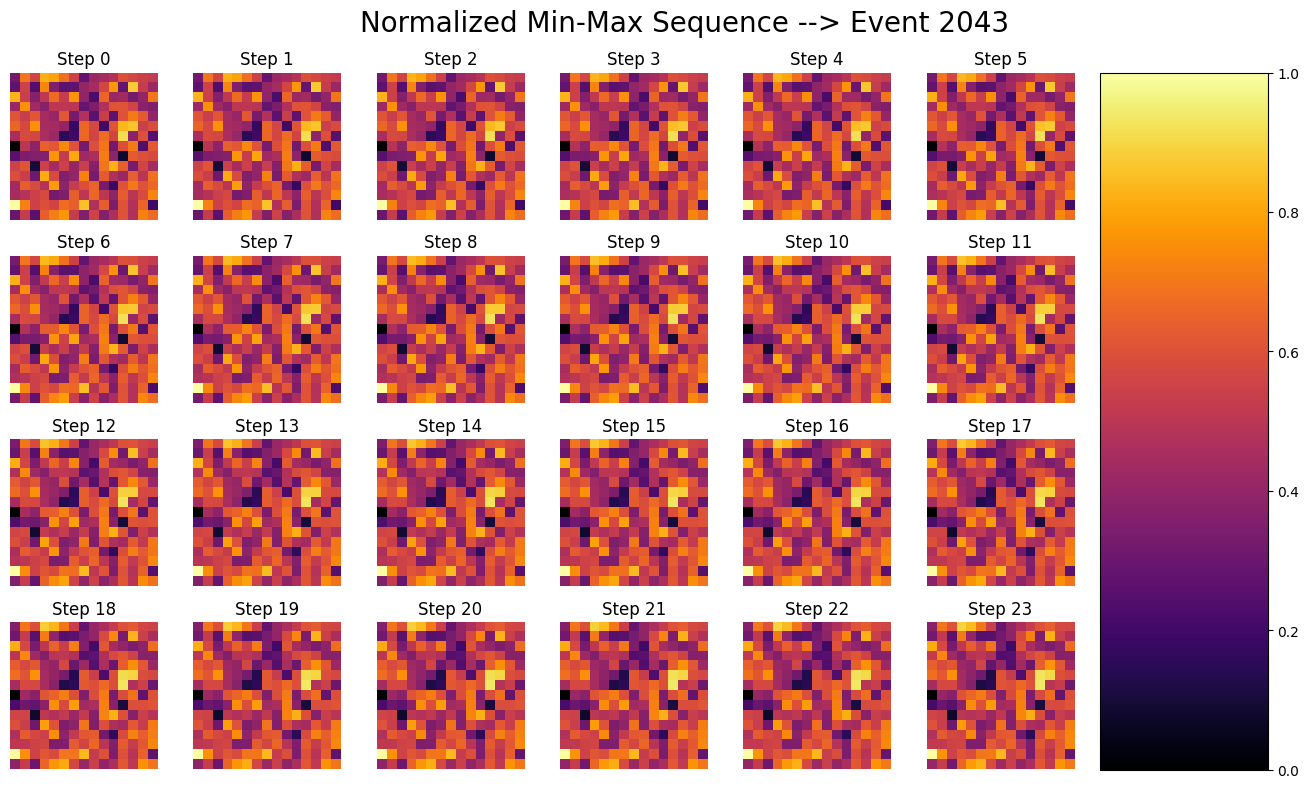

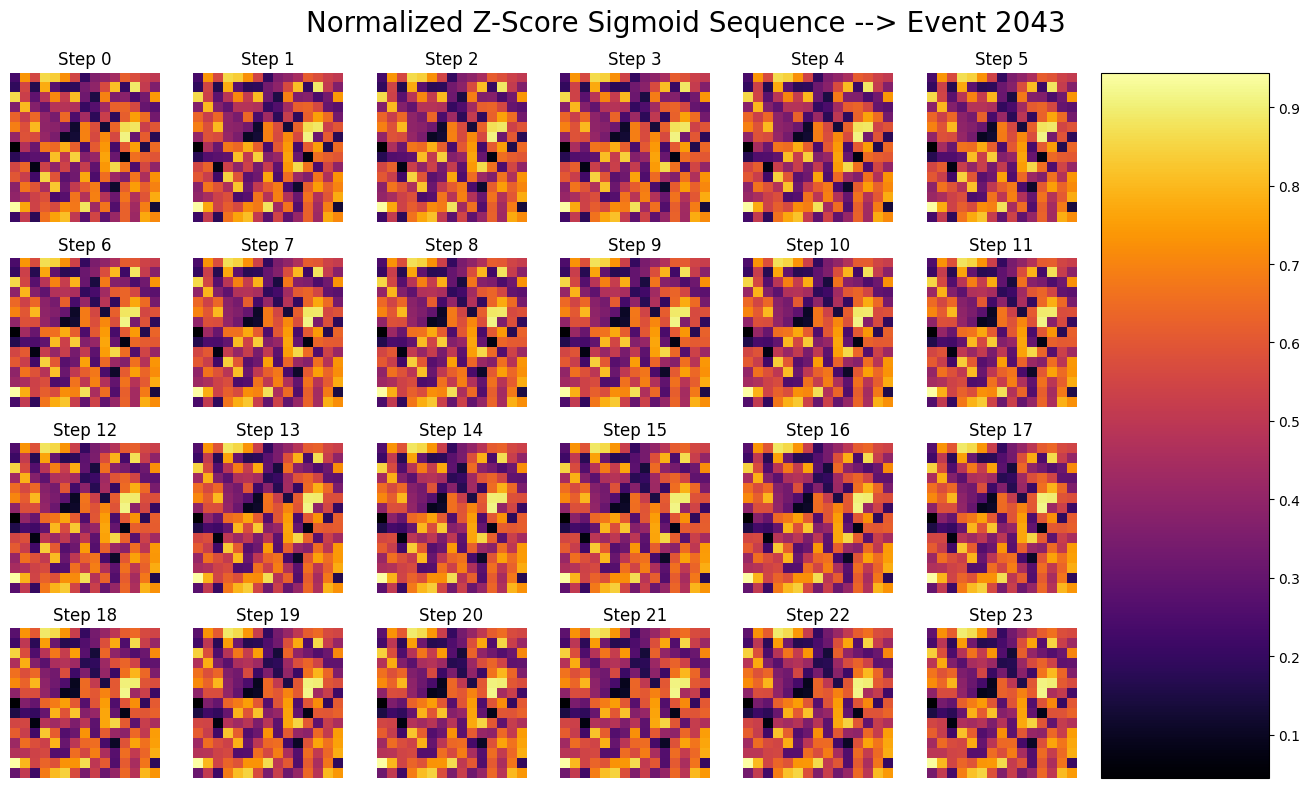

In [9]:
#This is a plotting cell to show the two different normalizations of the data
# In the future we will use the min-max normalization for the model but one can try the z-score normalization as well

idx = np.random.choice(range(len(normalize_sequences_min_max)))
vmin = normalize_sequences_min_max[idx].min().item()
vmax = normalize_sequences_min_max[idx].max().item()

fig = plt.figure(figsize=(14, 8))
gs = GridSpec(4, 7, figure=fig) 
axs = [fig.add_subplot(gs[i // 6, i % 6]) for i in range(24)]
for i, ax in enumerate(axs):
    im = ax.imshow(normalize_sequences_min_max[idx][i], cmap='inferno', vmin=vmin, vmax=vmax)
    ax.axis('off')
    ax.set_title(f"Step {i}")
fig.suptitle(f"Normalized Min-Max Sequence --> Event {idx}", fontsize=20)
cax = fig.add_subplot(gs[:, -1])
fig.colorbar(im, cax=cax, orientation='vertical')
plt.tight_layout(rect=[0, 0, 0.95, 1])
plt.show()

vmin = normalized_sequences_z_score_sigmoid[idx].min().item()
vmax = normalized_sequences_z_score_sigmoid[idx].max().item()

fig = plt.figure(figsize=(14, 8))
gs = GridSpec(4, 7, figure=fig)
axs = [fig.add_subplot(gs[i // 6, i % 6]) for i in range(24)]

for i, ax in enumerate(axs):
    im = ax.imshow(normalized_sequences_z_score_sigmoid[idx][i], cmap='inferno', vmin=vmin, vmax=vmax)
    ax.axis('off')
    ax.set_title(f"Step {i}")
fig.suptitle(f"Normalized Z-Score Sigmoid Sequence --> Event {idx}", fontsize=20)
cax = fig.add_subplot(gs[:, -1])
fig.colorbar(im, cax=cax, orientation='vertical')
plt.tight_layout(rect=[0, 0, 0.95, 1])
plt.show()


# DataLoading

In [10]:
import dgl
import torch

# Let's create a graph for each sequence where each node is an image of the sequence
graphs = []

#let's first reshape the dataPost to have the shape (n_sequences, n_steps, 15*15)
normalize_sequences_min_max = normalize_sequences_min_max.reshape(normalize_sequences_min_max.shape[0], normalize_sequences_min_max.shape[1], -1)
print(f"Reshaped data shape: {normalize_sequences_min_max.shape}")


for i in range(normalize_sequences_min_max.shape[0]):
    g = dgl.DGLGraph()
    g.add_nodes(normalize_sequences_min_max.shape[1]) # Adding a node for each step of the sequence
    g.ndata['x'] = torch.tensor(normalize_sequences_min_max[i], dtype=torch.float32) # Adding the features to each node
    g.ndata['step'] = torch.tensor(quenchPost[i]["step"], dtype=torch.int32)
    g.ndata['px'] = torch.tensor(quenchPost[i]["pixel_x"], dtype=torch.int32)
    g.ndata['py'] = torch.tensor(quenchPost[i]["pixel_y"], dtype=torch.int32)
    g.ndata['temp'] = torch.tensor(quenchPost[i]["temp"], dtype=torch.float32)
    # if the node has step -1 is a non quenching item otherwise is a quenching item
    g.ndata['label'] = torch.tensor([0 if step == -1 else 1 for step in quenchPost[i]["step"]], dtype=torch.int32)


    # Adding edges fully connecting the nodes 
    src, dst = [], []
    for j in range(normalize_sequences_min_max.shape[1]):
        for k in range(normalize_sequences_min_max.shape[1]):
            if j != k:
                src.append(j)
                dst.append(k)
    g.add_edges(src, dst)
    graphs.append(g)




print(graphs[9].ndata["x"])
print(graphs[9].ndata["step"])
print(graphs[9].ndata["temp"])
print(graphs[9].ndata["label"])



Reshaped data shape: (3000, 24, 225)


/Users/micheledandrea/Desktop/Progetti/conda_install/conda/envs/mlEnv/lib/python3.10/site-packages/dgl/heterograph.py:92: DGLWarning: Recommend creating graphs by `dgl.graph(data)` instead of `dgl.DGLGraph(data)`.
  dgl_warning(


tensor([[0.7218, 0.5182, 0.5202,  ..., 0.6785, 0.1344, 0.7536],
        [0.7222, 0.5222, 0.5234,  ..., 0.6780, 0.1402, 0.7535],
        [0.7226, 0.5262, 0.5267,  ..., 0.6775, 0.1459, 0.7534],
        ...,
        [0.4846, 0.3947, 0.3875,  ..., 0.4439, 0.1709, 0.4986],
        [0.4873, 0.3988, 0.3912,  ..., 0.4459, 0.1756, 0.5010],
        [0.4900, 0.4029, 0.3950,  ..., 0.4478, 0.1804, 0.5035]])
tensor([ 8, 10, 11, 13, 14, 17, 19, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
        -1, -1, -1, -1, -1, -1], dtype=torch.int32)
tensor([25.0312, 24.3415, 25.1656, 24.5923, 24.4450, 24.8953, 24.8885, -1.0000,
        -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
        -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000])
tensor([1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       dtype=torch.int32)


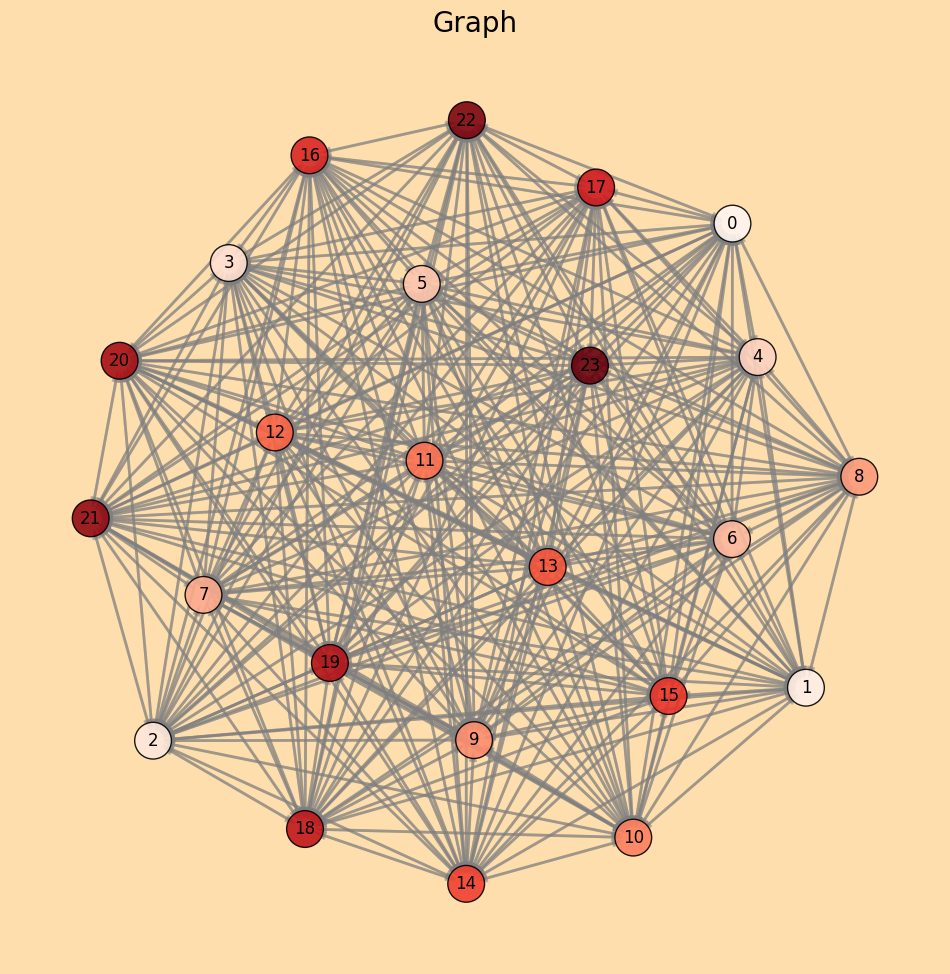

In [11]:
#Let's plot a graph to see how it looks like

import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

idx = np.random.choice(np.arange(len(graphs)))
G = graphs[idx].to_networkx()
pos = nx.spring_layout(G, seed=42)  

fig, ax = plt.subplots(figsize=(12, 12))


nodes = nx.draw_networkx_nodes(G, pos, node_color=range(len(G.nodes)), cmap=plt.cm.Reds, node_size=700, alpha=0.9, ax=ax)
nodes.set_edgecolor('black')  


edges = nx.draw_networkx_edges(G, pos, width=2.0, alpha=0.5, edge_color='gray', ax=ax)


labels_ = nx.draw_networkx_labels(G, pos, font_size=12, font_color='black', ax=ax)


ax.set_facecolor('navajowhite')
ax.axis('off')
fig.set_facecolor('navajowhite')


plt.title('Graph', fontsize=20)

plt.show()


### DataLoader

In [12]:
#let's define a data loader for the dataset
from dgl.data import DGLDataset
from torch.utils.data.sampler import WeightedRandomSampler, RandomSampler
from dgl.dataloading import GraphDataLoader
import dgl.data
import numpy as np

class GraphDataset(DGLDataset):
    def __init__(self, graphs, labels):
        self.graphs = graphs
        self.labels = labels
        super().__init__(name='my_graph_dataset')

    def process(self):
        # Here you can preprocess your graphs and labels if needed
        pass

    def __getitem__(self, idx):
        return self.graphs[idx], self.labels[idx]

    def __len__(self):
        return len(self.graphs)


labelsTensor = [torch.tensor(label) for label in labels]
print(labelsTensor)



dataset = GraphDataset(graphs, labelsTensor)
print(f"Dataset length: {len(dataset)}")


#let's split the dataset in training and validation and test

n_Graphs = len(dataset)
n_train = int(n_Graphs * 0.6)
n_val = int(n_Graphs * 0.1)
n_test = n_Graphs - n_train - n_val

indices = torch.randperm(n_Graphs)
#let's check if in the indices there are repeated values
print(f"Number of unique indices: {len(torch.unique(indices))}")

train_idx = indices[:n_train]
val_idx = indices[n_train:n_train + n_val]
test_idx = indices[n_train + n_val:]

#let's check if the train, val and test sets are disjoint
print(f"Train and validation sets are disjoint: {len(set(train_idx).intersection(set(val_idx))) == 0}")
print(f"Train and test sets are disjoint: {len(set(train_idx).intersection(set(test_idx))) == 0}")
print(f"Validation and test sets are disjoint: {len(set(val_idx).intersection(set(test_idx))) == 0}")


# Create subsets of the dataset
train_subset = torch.utils.data.Subset(dataset, train_idx)
val_subset = torch.utils.data.Subset(dataset, val_idx)
test_subset = torch.utils.data.Subset(dataset, test_idx)


# We should create a weighted sampler to balance the classes #--> This is done to avoid the model to be biased towards the majority class
#                                                            #--> In principle one could use also class weight in the loss function to balance the classes
weights = 1 / np.bincount(labelsTensor)
weights /= weights.sum()
print(f"Class weights: {weights}")
weightsTensor = weights[labelsTensor]
print(f"Weighted labels: {weightsTensor}")



train_sampler = WeightedRandomSampler(weightsTensor[train_idx], len(train_idx), replacement=True)
#val_sampler = WeightedRandomSampler(weightsTensor[val_idx], len(val_idx), replacement=True) #--> due to lack of stat I prefer to use an UnWeighted sampler for the validation set



print("\n#---------------TRAININGSET-----------------#")
print(f"Train sampler number of events: {len(train_sampler)}")
labels_train = labels[train_idx]
labels_train = labels_train[list(train_sampler)]
print(f"labels_train -> {labels_train[:30]}")
n_Unquench = len(labels_train[labels_train == 0])
n_Quench = len(labels_train[labels_train == 1])
print(f"Percentage of quenching events in the training set: {n_Quench / len(labels_train) * 100:.2f}%")
print(f"Percentage of non quenching events in the training set: {n_Unquench / len(labels_train) * 100:.2f}%")
print("#-----------------------------------------#\n")

#print("\n#---------------VALIDATIONSET-----------------#")
#print(f"Validation sampler number of events: {len(val_sampler)}")
#labels_val = labels[val_idx]
#labels_val = labels_val[list(val_sampler)]
#n_Unquench = len(labels_val[labels_val == 0])
#n_Quench = len(labels_val[labels_val == 1])
#print(f"Percentage of quenching events in the validation set: {n_Quench / len(labels_val) * 100:.2f}%")
#print(f"Percentage of non quenching events in the validation set: {n_Unquench / len(labels_val) * 100:.2f}%")
#print("#-----------------------------------------#\n")


# Creating the data loaders
batchSize = 1


train_loader = GraphDataLoader(train_subset, sampler=train_sampler, batch_size=batchSize, drop_last=False)
val_loader = GraphDataLoader(val_subset, batch_size=batchSize, drop_last=False, shuffle = True)
test_loader = GraphDataLoader(test_subset, batch_size=batchSize, drop_last=False, shuffle = True)




# Let's check the data loader
print("\n#---------------Checking the data loader-----------------#")
it = iter(train_loader)
batch = next(it)
print(f"Batch data: {batch[0]}")
print(f"Batch labels: {batch[1]}")
print("#-------------------------------------------------------#\n")


[tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(1), tensor(1), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(1), tensor(1), tensor(0), tensor(1), tensor(1), tensor(1), tensor(0), tensor(0), tensor(0), tensor(0), tensor(1), tensor(0), tensor(0), tensor(1), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(1), tensor(0), tensor(1), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(1), tensor(0), tensor(0), tensor(0), tensor(0), tensor(1), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0)

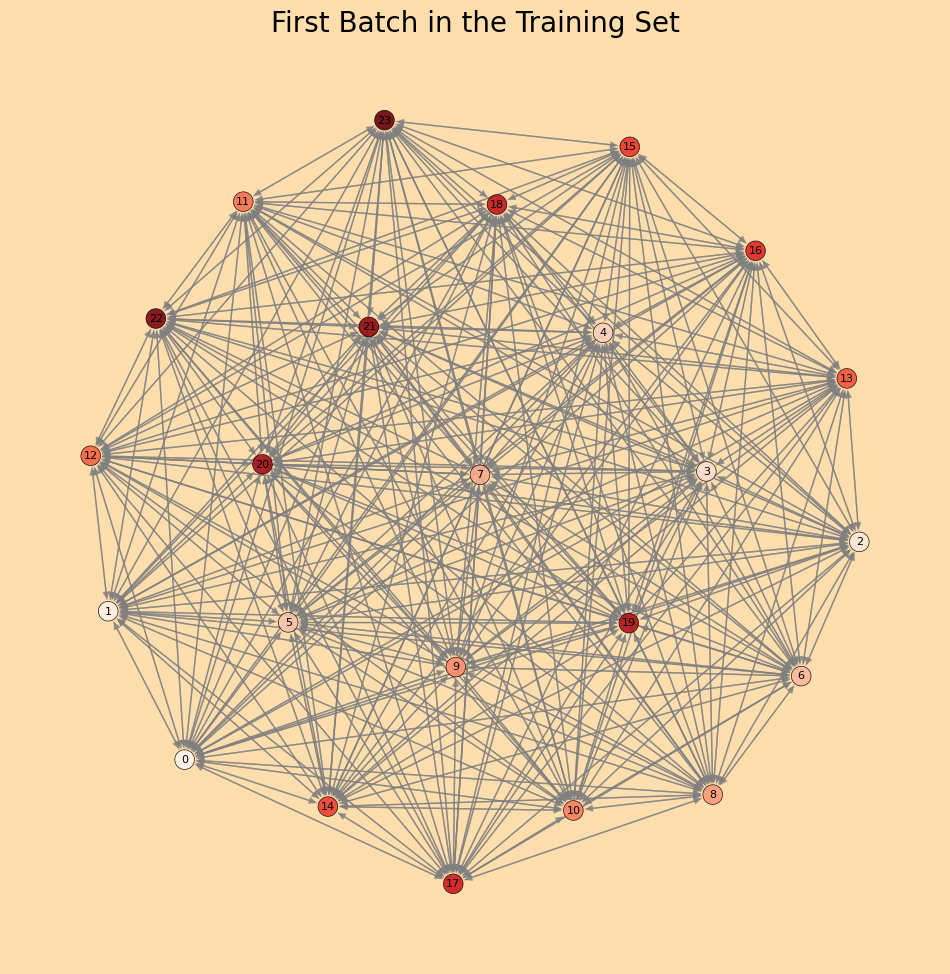

In [13]:
#Let's plot the first batch of the training set

import networkx as nx
import matplotlib.pyplot as plt


G = batch[0].to_networkx()
seed_ = np.random.randint(0, 1000)
pos = nx.spring_layout(G, seed=seed_, k=0.5)  

fig, ax = plt.subplots(figsize=(12, 12))

nodes = nx.draw_networkx_nodes(
    G, pos, node_color=range(G.number_of_nodes()), cmap=plt.cm.Reds, 
    node_size=200, edgecolors='black', linewidths=0.5, alpha=0.9, ax=ax
)

edges = nx.draw_networkx_edges(
    G, pos, width=1.0, alpha=0.7, edge_color='gray', ax=ax
)

labels_ = nx.draw_networkx_labels(
    G, pos, font_size=8, font_color='black', ax=ax
)

ax.set_facecolor('navajowhite')
ax.axis('off')
fig.set_facecolor('navajowhite')


plt.title('First Batch in the Training Set', fontsize=20)

plt.show()


# TASK 1: Identify if a sequence has quanches 

### loss and models definition

In [51]:
import torch.nn.functional as F
import torch
import numpy as np

def loss_function(pred, label, pos_weight=None, neg_weight=None, batch_size=None):
    return F.cross_entropy(pred, label)


# Define the accuracy function
def accuracy(pred, label):
    # Convert logits to predicted class indices
    pred_class = torch.argmax(pred, dim=1)
    
    # Flatten the predicted and true labels
    pred_class = pred_class.view(-1)
    label = label.view(-1)
    
    # Calculate the number of correct predictions
    correct = (pred_class == label).sum().item()
    
    # Compute accuracy
    accuracy = correct / len(label)
    return accuracy


# Training function
def train(model, optimizer, data_loader, scheduler=None):
    model.train()
    total_loss = 0
    total_acc = 0
    for batched_graph, labels in data_loader:
        pred = model(batched_graph, batched_graph.ndata['x'])
        loss = loss_function(pred, labels)
        acc = accuracy(pred, labels)
        #print(f"pred-> {torch.sigmoid(pred.view(-1))}") # --> debug print
        #print(f"labels-> {labels}") # --> debug print
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if scheduler is not None:
            scheduler.step(loss)
        total_loss += loss.detach().item()
        total_acc += acc
    #print(f"pred-> {torch.sigmoid(pred.view(-1))}") # --> debug print
    #print(f"labels-> {labels}") # --> debug print
    return total_loss / len(data_loader), total_acc / len(data_loader)

# Evaluation function
def evaluate(model, data_loader):
    model.eval()
    total_loss = 0
    total_acc = 0
    p_Unquench = np.array([])
    p_Quench = np.array([])
    
    labels_eval = np.array([])
    with torch.no_grad():
        for batched_graph, labels in data_loader:
            pred = model(batched_graph, batched_graph.ndata['x'])
            loss = loss_function(pred, labels)
            acc = accuracy(pred, labels)
            total_loss += loss.detach().item()
            total_acc += acc
            p_Unquench = np.concatenate((p_Unquench, torch.softmax(pred, dim=1).numpy()[:, 0]))
            p_Quench = np.concatenate((p_Quench, torch.softmax(pred, dim=1).numpy()[:, 1]))
            labels_eval = np.concatenate((labels_eval, labels.numpy()))
    predictions_eval = np.stack((p_Unquench, p_Quench), axis=0)
        
    return total_loss / len(data_loader), total_acc / len(data_loader), predictions_eval, labels_eval


#### A simple GNN with graph convolution

In [18]:
# Defining a first simple model
import torch
import torch.nn as nn
import torch.nn.functional as F
import dgl.nn as dglnn
from torch.optim.lr_scheduler import ReduceLROnPlateau

class GCN(nn.Module):
    def __init__(self, in_feats, hidden_sizes):
        super(GCN, self).__init__()
        layers = []
        self.layer_labels = []

        # Define Graph Convolutional layers and ReLU activations
        for i in range(len(hidden_sizes)):
            if i == 0:
                layers.append(dglnn.GraphConv(in_feats, hidden_sizes[i]))
            else:
                layers.append(dglnn.GraphConv(hidden_sizes[i-1], hidden_sizes[i]))
            layers.append(nn.ReLU())
            self.layer_labels.append(f"GCN_{i}")
            self.layer_labels.append("ReLU")

        self.layers = nn.ModuleList(layers)
        self.fc = nn.Linear(hidden_sizes[-1], 2)

    def forward(self, g, x):
        for layer, label in zip(self.layers, self.layer_labels):
            if label[:3] == "GCN":
                x = layer(g, x)
            else:
                x = layer(x)
        g.ndata['h'] = x
        hg = dgl.mean_nodes(g, 'h')
        return self.fc(hg)


hidden_sizes = [128, 64, 32, 16, 8]
model_gnn = GCN(15*15, hidden_sizes)
optimizer = torch.optim.Adam(model_gnn.parameters(), lr=0.001)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.99, patience=2000, verbose=False, min_lr=1e-5)


In [19]:
# Training the model and saving the ckpts
import os
import shutil

# Directory to save the models
save_dir = 'logs/model_gnn/'

# Remove the existing directory if it exists
if os.path.exists(save_dir):
    shutil.rmtree(save_dir)

os.makedirs(save_dir, exist_ok=True)

num_epochs = 50
train_losses = []
val_losses = []
for epoch in range(num_epochs):
    train_loss, train_acc = train(model_gnn, optimizer, train_loader, scheduler)
    val_loss, val_acc, predictions_eval, labels_eval = evaluate(model_gnn, val_loader)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    # Save the model at each epoch
    model_path = os.path.join(save_dir, f'model_epoch_{epoch}_loss_{val_loss:.4f}.pth')
    torch.save({
        'epoch': epoch,
        'model_state_dict': model_gnn.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': val_loss,
    }, model_path)
    print(f"lr-> {optimizer.param_groups[0]['lr']}")
    print(f"Epoch {epoch + 1}/{num_epochs} -> Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
    

lr-> 0.001
Epoch 1/50 -> Train Loss: 0.6913, Train Acc: 0.5289, Val Loss: 0.5672, Val Acc: 0.8900
lr-> 0.00099
Epoch 2/50 -> Train Loss: 0.6173, Train Acc: 0.6522, Val Loss: 0.3325, Val Acc: 0.9000
lr-> 0.00099
Epoch 3/50 -> Train Loss: 0.4505, Train Acc: 0.7844, Val Loss: 0.3156, Val Acc: 0.8767
lr-> 0.00099
Epoch 4/50 -> Train Loss: 0.3991, Train Acc: 0.8233, Val Loss: 0.5847, Val Acc: 0.7233
lr-> 0.0009801
Epoch 5/50 -> Train Loss: 0.3830, Train Acc: 0.8383, Val Loss: 0.4269, Val Acc: 0.8000
lr-> 0.0009801
Epoch 6/50 -> Train Loss: 0.3308, Train Acc: 0.8639, Val Loss: 0.2800, Val Acc: 0.8833
lr-> 0.000970299
Epoch 7/50 -> Train Loss: 0.3389, Train Acc: 0.8622, Val Loss: 0.5178, Val Acc: 0.7433
lr-> 0.0009605960099999999
Epoch 8/50 -> Train Loss: 0.3513, Train Acc: 0.8539, Val Loss: 0.3509, Val Acc: 0.8267
lr-> 0.0009605960099999999
Epoch 9/50 -> Train Loss: 0.3090, Train Acc: 0.8639, Val Loss: 0.9047, Val Acc: 0.5500
lr-> 0.0009509900498999999
Epoch 10/50 -> Train Loss: 0.3349, Trai

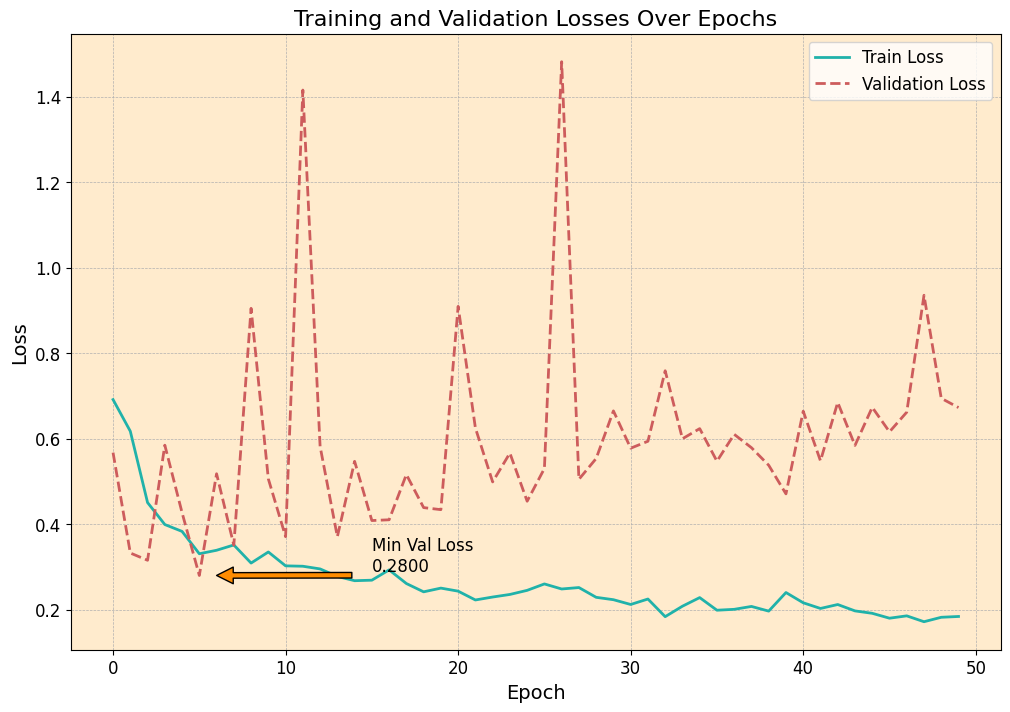

In [20]:
import matplotlib.pyplot as plt

# Plotting the losses
plt.figure(figsize=(12, 8))

plt.plot(train_losses, label='Train Loss', color='lightseagreen', linestyle='-', linewidth=2)
plt.plot(val_losses, label='Validation Loss', color='indianred', linestyle='--', linewidth=2)

plt.title('Training and Validation Losses Over Epochs', fontsize=16)
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Loss', fontsize=14)


plt.xticks(fontsize=12)
plt.yticks(fontsize=12)


plt.grid(True, which='both', linestyle='--', linewidth=0.5)


plt.legend(loc='upper right', fontsize=12)

min_val_loss_epoch = val_losses.index(min(val_losses))
plt.annotate(f'Min Val Loss\n{min(val_losses):.4f}', 
             xy=(min_val_loss_epoch, min(val_losses) +0.00), 
             xytext=(min_val_loss_epoch + 10, min(val_losses) + 0.01),
             arrowprops=dict(facecolor='darkorange', shrink=0.1),
             fontsize=12, 
             color='black')

plt.gca().set_facecolor('blanchedalmond')
plt.show()




#### Graph Attention Network

In [21]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from dgl.nn import GATConv, GlobalAttentionPooling

# First Embedding MLP to map the initial node features
class EmbeddingMLP(nn.Module):
    def __init__(self, in_feats, hiddenSizes, out_feats):
        super(EmbeddingMLP, self).__init__()
        layers = []
        for hidden_size in hiddenSizes:
            layers.append(nn.Linear(in_feats, hidden_size))
            layers.append(nn.ReLU())
            in_feats = hidden_size
        layers.append(nn.Linear(in_feats, out_feats))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)
    
# A second MLP to classify the graph w/o any activation function
class ClassificationMLP(nn.Module):
    def __init__(self, in_feats, hiddenSizes, out_feats):
        super(ClassificationMLP, self).__init__()
        layers = []
        for hidden_size in hiddenSizes:
            layers.append(nn.Linear(in_feats, hidden_size))
            in_feats = hidden_size
        layers.append(nn.Linear(in_feats, out_feats))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

# The GAT model
class GAT(nn.Module):
    def __init__(self, in_feats, hiddenSizesEmbedding, hiddenSizesClassification, OutputEmbedding, OutputClassification, num_heads=4):
        super(GAT, self).__init__()
        self.embeddingMlp = EmbeddingMLP(in_feats, hiddenSizesEmbedding, OutputEmbedding)
        self.gat1 = GATConv(OutputEmbedding, 4, num_heads=num_heads, activation=F.elu)
        gate_nn = nn.Linear(4 * num_heads, 1)  
        self.gap = GlobalAttentionPooling(gate_nn)
        self.ClassifyGraph = ClassificationMLP(4 * num_heads, hiddenSizesClassification, OutputClassification) # Classificatore per il grafo

    def forward(self, g, features):
        # Step 1: Node embedding
        updated_features = self.embeddingMlp(features)
        
        # Step 2: GAT layer
        g.ndata['h'] = updated_features
        h = self.gat1(g, g.ndata['h']).flatten(1)
        g.ndata['h'] = h
        #print(f"h-> {h}") # --> debug print
        
        # Step: Global Attention Pooling
        hg = self.gap(g, h)

        # Step: Graph classification
        graph_class = self.ClassifyGraph(hg)

        return graph_class


EMbeddingSizes = [64, 32, 16]
ClassificationSizes = [8,4]
OutputEmbedding = 8
OutputClassification = 2
model_gat = GAT(15*15, EMbeddingSizes, ClassificationSizes, OutputEmbedding, OutputClassification)
optimizer = torch.optim.Adam(model_gat.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.99, patience=2000, verbose=False, min_lr=1e-5)



In [22]:
# Training the model and saving the ckpts
import os
import shutil

# Directory to save the models
save_dir = 'logs/model_gat/'

# Remove the existing directory if it exists
if os.path.exists(save_dir):
    shutil.rmtree(save_dir)

os.makedirs(save_dir, exist_ok=True)

num_epochs = 50
train_losses = []
val_losses = []
for epoch in range(num_epochs):
    train_loss, train_acc = train(model_gat, optimizer, train_loader, scheduler)
    val_loss, val_acc, predictions_eval, labels_eval = evaluate(model_gat, val_loader)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    # Save the model at each epoch
    model_path = os.path.join(save_dir, f'model_epoch_{epoch}_loss_{val_loss:.4f}.pth')
    torch.save({
        'epoch': epoch,
        'model_state_dict': model_gat.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': val_loss,
    }, model_path)
    print(f"lr-> {optimizer.param_groups[0]['lr']}")
    print(f"Epoch {epoch + 1}/{num_epochs} -> Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
    

lr-> 0.001
Epoch 1/50 -> Train Loss: 0.6819, Train Acc: 0.5628, Val Loss: 0.6779, Val Acc: 0.6033
lr-> 0.001
Epoch 2/50 -> Train Loss: 0.3543, Train Acc: 0.8422, Val Loss: 0.1056, Val Acc: 0.9567
lr-> 0.001
Epoch 3/50 -> Train Loss: 0.1985, Train Acc: 0.9256, Val Loss: 0.2816, Val Acc: 0.8867
lr-> 0.00099
Epoch 4/50 -> Train Loss: 0.1520, Train Acc: 0.9444, Val Loss: 0.1123, Val Acc: 0.9600
lr-> 0.00099
Epoch 5/50 -> Train Loss: 0.1595, Train Acc: 0.9361, Val Loss: 0.0940, Val Acc: 0.9533
lr-> 0.0009801
Epoch 6/50 -> Train Loss: 0.1316, Train Acc: 0.9583, Val Loss: 1.4763, Val Acc: 0.5567
lr-> 0.000970299
Epoch 7/50 -> Train Loss: 0.1250, Train Acc: 0.9528, Val Loss: 0.2615, Val Acc: 0.9000
lr-> 0.0009605960099999999
Epoch 8/50 -> Train Loss: 0.1183, Train Acc: 0.9589, Val Loss: 0.1153, Val Acc: 0.9500
lr-> 0.0009509900498999999
Epoch 9/50 -> Train Loss: 0.1025, Train Acc: 0.9672, Val Loss: 0.1200, Val Acc: 0.9533
lr-> 0.0009509900498999999
Epoch 10/50 -> Train Loss: 0.1118, Train Acc:

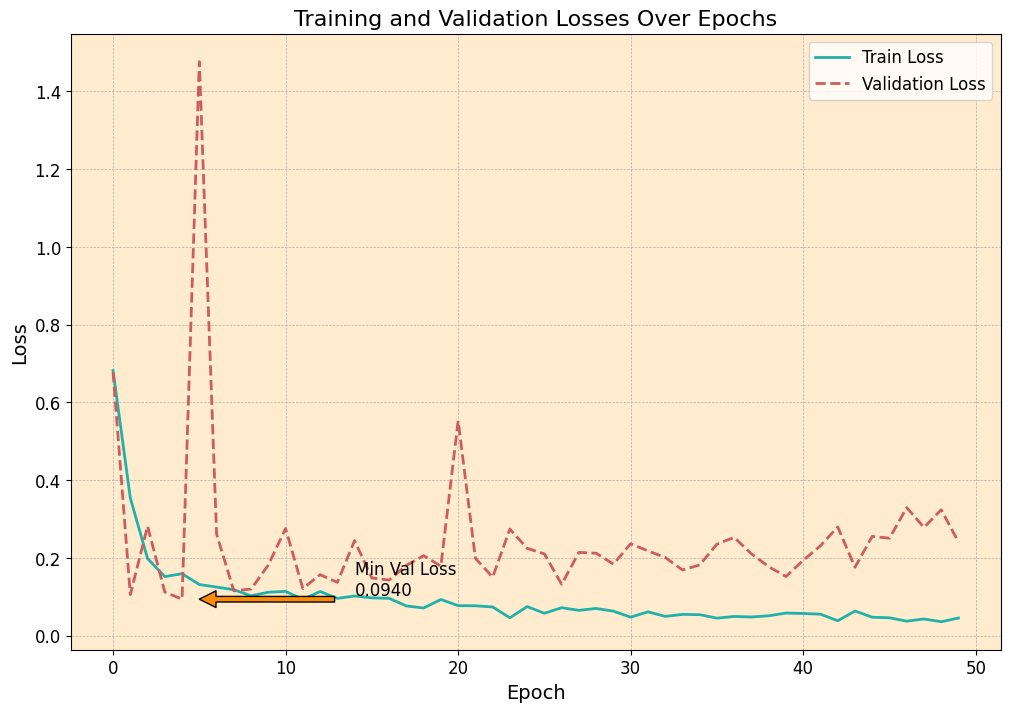

In [23]:
import matplotlib.pyplot as plt

# Plotting the losses
plt.figure(figsize=(12, 8))

# Plotting train and validation losses
plt.plot(train_losses, label='Train Loss', color='lightseagreen', linestyle='-', linewidth=2)
plt.plot(val_losses, label='Validation Loss', color='indianred', linestyle='--', linewidth=2)

# Adding titles and labels
plt.title('Training and Validation Losses Over Epochs', fontsize=16)
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Loss', fontsize=14)

# Customizing ticks
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Adding grid
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# Adding legend
plt.legend(loc='upper right', fontsize=12)

# Adding annotations for minimum validation loss
min_val_loss_epoch = val_losses.index(min(val_losses))
plt.annotate(f'Min Val Loss\n{min(val_losses):.4f}', 
             xy=(min_val_loss_epoch, min(val_losses) +0.00), 
             xytext=(min_val_loss_epoch + 10, min(val_losses) + 0.01),
             arrowprops=dict(facecolor='darkorange', shrink=0.1),
             fontsize=12, 
             color='black')

#let's add a background color to the plot
plt.gca().set_facecolor('blanchedalmond')
plt.show()




## Evaluate the models on the test set

In [49]:
import torch
import re
import os


def get_checkpoint_with_min_loss(directory):
    """
    Scans the given directory for checkpoint files and returns the path of the checkpoint with the minimum validation loss.

    Args:
        directory (str): The directory containing the checkpoint files.

    Returns:
        str: The path to the checkpoint with the minimum validation loss.
    """
    checkpoint_files = [f for f in os.listdir(directory) if f.startswith('model_epoch_') and f.endswith('.pth')]
    
    min_loss = float('inf')
    min_loss_checkpoint = None

    for checkpoint_file in checkpoint_files:
        # Extract the loss from the filename using regex
        match = re.search(r'model_epoch_\d+_loss_([0-9]*\.[0-9]+)\.pth', checkpoint_file)
        if match:
            loss = float(match.group(1))
            if loss < min_loss:
                min_loss = loss
                min_loss_checkpoint = os.path.join(directory, checkpoint_file)

    return min_loss_checkpoint

try:
    # Define the path to the checkpoint you want to load
    gat_dir = 'logs/model_gat/'
    gnn_dir = 'logs/model_gnn/'

    # Load the checkpoint
    checkpoint_gat = torch.load(get_checkpoint_with_min_loss(gat_dir))
    checkpoint_gnn = torch.load(get_checkpoint_with_min_loss(gnn_dir))

    # Restore the model state
    model_gat.load_state_dict(checkpoint_gat['model_state_dict'])
    model_gnn.load_state_dict(checkpoint_gnn['model_state_dict'])

    # Retrieve additional information if needed
    epoch_gat = checkpoint_gat['epoch']
    loss_gat = checkpoint_gat['loss']
    epoch_gnn = checkpoint_gnn['epoch']
    loss_gnn = checkpoint_gnn['loss']

    # Set the model to evaluation mode (if you plan to use it for inference)
    model_gat.eval()
    model_gnn.eval()

    print(f'Graph Attention Network model restored from epoch {epoch_gat} with validation loss {loss_gat:.4f}')
    print(f'Graph Neural Network model restored from epoch {epoch_gnn} with validation loss {loss_gnn:.4f}')
except FileNotFoundError:
    print('###ERROR### ----> Checkpoint not found. Probably you need to train the model first.')
except NameError:
    print('###ERROR### ----> Model not defined. Probably you need to define the model first. Just run the cell containing the model definition.')



Graph Attention Network model restored from epoch 4 with validation loss 0.0940
Graph Neural Network model restored from epoch 5 with validation loss 0.2800


Graph Attention Network -> Test Loss: 0.1091, Test Acc: 0.9600
Graph Neural Network -> Test Loss: 0.2675, Test Acc: 0.8978
Graph Attention Network -> Test Predictions: (2, 900)
Graph Attention Network -> Test Labels: (900,)
Graph Neural Network -> Test Predictions: (2, 900)
Graph Neural Network -> Test Labels: (900,)


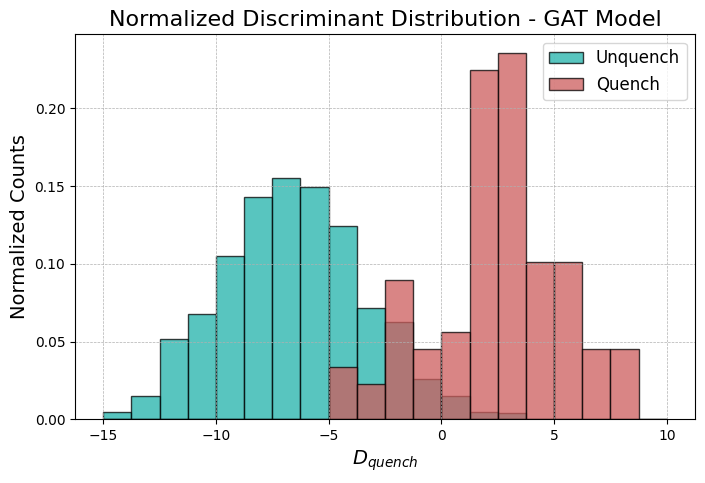

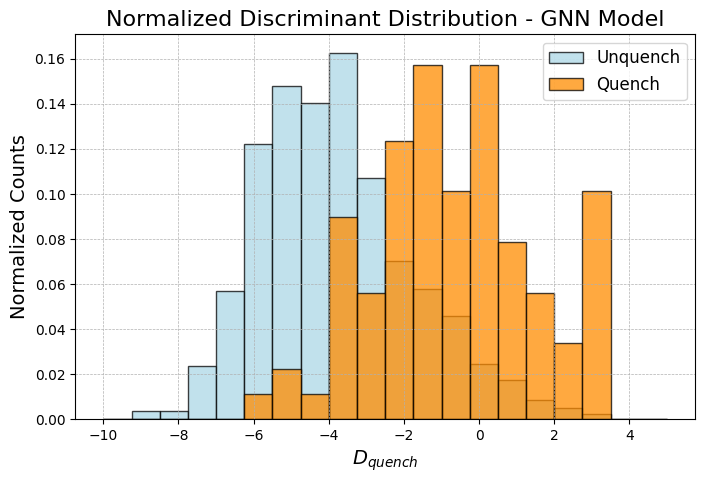

In [52]:
import numpy as np

#let's loop over the test batch and evaluate the model
test_loss_gat, test_acc_gat, predictions_test_gat, labels_test_gat = evaluate(model_gat, test_loader)
test_loss_gnn, test_acc_gnn, predictions_test_gnn, labels_test_gnn = evaluate(model_gnn, test_loader)

print(f"Graph Attention Network -> Test Loss: {test_loss_gat:.4f}, Test Acc: {test_acc_gat:.4f}")
print(f"Graph Neural Network -> Test Loss: {test_loss_gnn:.4f}, Test Acc: {test_acc_gnn:.4f}")

print(f"Graph Attention Network -> Test Predictions: {predictions_test_gat.shape}")
print(f"Graph Attention Network -> Test Labels: {labels_test_gat.shape}")

print(f"Graph Neural Network -> Test Predictions: {predictions_test_gnn.shape}")
print(f"Graph Neural Network -> Test Labels: {labels_test_gnn.shape}")


gat_Unquench_pUnquench = predictions_test_gat[0][labels_test_gat == 0]
gat_Unquench_pQuench = predictions_test_gat[1][labels_test_gat == 0]

gat_Quench_pUnquench = predictions_test_gat[0][labels_test_gat == 1]
gat_Quench_pQuench = predictions_test_gat[1][labels_test_gat == 1]


def Discr(pQuench,pUnquench):
    return np.log(pQuench/pUnquench)

gat_Unquench_Discr = Discr(gat_Unquench_pQuench, gat_Unquench_pUnquench)
gat_Quench_Discr = Discr(gat_Quench_pQuench, gat_Quench_pUnquench)

# Normalize the histograms
weights_unquench = np.ones_like(gat_Unquench_Discr) / len(gat_Unquench_Discr)
weights_quench = np.ones_like(gat_Quench_Discr) / len(gat_Quench_Discr)

# Plotting the normalized discriminant for the GAT model
plt.figure(figsize=(8, 5))
plt.hist(gat_Unquench_Discr, bins=20, weights=weights_unquench, alpha=0.75, color='lightseagreen', label='Unquench', edgecolor='black', range=(-15, 10))
plt.hist(gat_Quench_Discr, bins=20, weights=weights_quench, alpha=0.75, color='indianred', label='Quench', edgecolor='black', range=(-15, 10))

# Adding titles and labels
plt.xlabel(r'$D_{quench}$', fontsize=14)
plt.ylabel('Normalized Counts', fontsize=14)
plt.title('Normalized Discriminant Distribution - GAT Model', fontsize=16)

# Adding legend
plt.legend(fontsize=12)

# Adding grid
plt.grid(True, which='both', linestyle='--', linewidth=0.5)


plt.show()

#Now let's do the same for the GNN model
gnn_Unquench_pUnquench = predictions_test_gnn[0][labels_test_gnn == 0]
gnn_Unquench_pQuench = predictions_test_gnn[1][labels_test_gnn == 0]

gnn_Quench_pUnquench = predictions_test_gnn[0][labels_test_gnn == 1]
gnn_Quench_pQuench = predictions_test_gnn[1][labels_test_gnn == 1]

gnn_Unquench_Discr = Discr(gnn_Unquench_pQuench, gnn_Unquench_pUnquench)
gnn_Quench_Discr = Discr(gnn_Quench_pQuench, gnn_Quench_pUnquench)


# Normalize the histograms
weights_unquench = np.ones_like(gnn_Unquench_Discr) / len(gnn_Unquench_Discr)
weights_quench = np.ones_like(gnn_Quench_Discr) / len(gnn_Quench_Discr)

# Plotting the normalized discriminant for the GNN model
plt.figure(figsize=(8, 5))
plt.hist(gnn_Unquench_Discr, bins=20, weights=weights_unquench, alpha=0.75, color='lightblue', label='Unquench', edgecolor='black', range=(-10, 5))
plt.hist(gnn_Quench_Discr, bins=20, weights=weights_quench, alpha=0.75, color='darkorange', label='Quench', edgecolor='black', range=(-10, 5))

# Adding titles and labels
plt.xlabel(r'$D_{quench}$', fontsize=14)
plt.ylabel('Normalized Counts', fontsize=14)
plt.title('Normalized Discriminant Distribution - GNN Model', fontsize=16)

# Adding legend
plt.legend(fontsize=12)

# Adding grid
plt.grid(True, which='both', linestyle='--', linewidth=0.5)


plt.show()








[23.5        24.16666667 21.         21.71428571 17.66666667 13.41666667
 11.73333333 11.15789474 11.2173913  10.4         6.92105263  5.18181818
  5.15789474  5.48333333  5.78333333  4.96        3.66055046  3.544
  2.86829268  2.86721992]


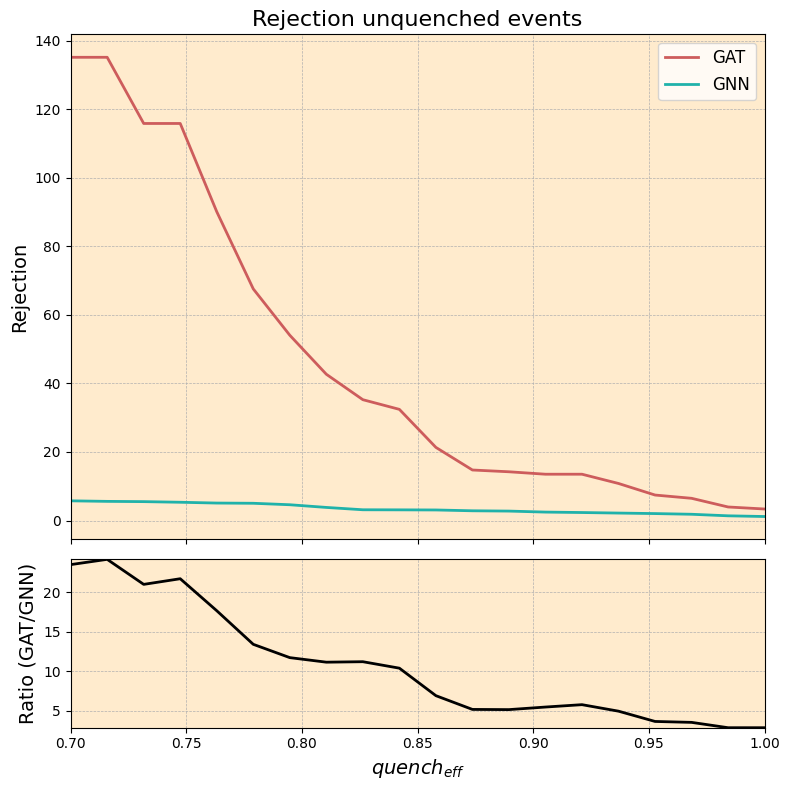

In [53]:
import numpy as np
import matplotlib.pyplot as plt

def calc_rej(sig_eff, D_sig, D_bkg):
    rej_array = np.array([])
    for eff in sig_eff:
        d_cut = np.percentile(D_sig, 100 - eff*100)
        mistag_eff = sum(D_bkg > d_cut)/D_bkg.shape[0]
        rej = 1./mistag_eff
        rej_array = np.append(rej_array, rej)
        #print(f"eff->{eff}, d_cut-> {d_cut}, n_mistagged ->{sum(D_bkg > d_cut)}")
    return rej_array

quench_eff = np.linspace(0.7, 1, 20)
gat_rej = calc_rej(quench_eff, gat_Quench_Discr, gat_Unquench_Discr)
gnn_rej = calc_rej(quench_eff, gnn_Quench_Discr, gnn_Unquench_Discr)

# Calcolare il rapporto tra le curve
ratio = gat_rej / gnn_rej

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 8), sharex=True, gridspec_kw={'height_ratios': [3, 1]})


ax1.plot(quench_eff, gat_rej, color="indianred", label="GAT", lw=2)
ax1.plot(quench_eff, gnn_rej, color="lightseagreen", label="GNN", lw=2)
ax1.set_ylabel('Rejection', fontsize=14)
ax1.set_title('Rejection unquenched events', fontsize=16)
ax1.legend(fontsize=12)
ax1.grid(True, which='both', linestyle='--', linewidth=0.5)
ax1.set_facecolor('blanchedalmond')

# ratio plot
print(ratio)
ax2.plot(quench_eff, ratio, color="black", lw=2)
ax2.set_xlabel(r'$quench_{eff}$', fontsize=14)
ax2.set_ylabel('Ratio (GAT/GNN)', fontsize=14)
ax2.grid(True, which='both', linestyle='--', linewidth=0.5)
ax2.set_facecolor('blanchedalmond')


ax1.set_xlim([quench_eff.min(), quench_eff.max()])
ax2.set_ylim([ratio.min(), ratio.max()])

plt.tight_layout()
plt.show()


# TASK 2: Infer the number of quenches in a sequence

### A new GAT model with two task

In [41]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from dgl.nn import GATConv, GlobalAttentionPooling

class EmbeddingMLP(nn.Module):
    def __init__(self, in_feats, hiddenSizes, out_feats):
        super(EmbeddingMLP, self).__init__()
        layers = []
        for hidden_size in hiddenSizes:
            layers.append(nn.Linear(in_feats, hidden_size))
            layers.append(nn.ReLU())
            in_feats = hidden_size
        layers.append(nn.Linear(in_feats, out_feats))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

class ClassificationMLP(nn.Module):
    def __init__(self, in_feats, hiddenSizes, out_feats):
        super(ClassificationMLP, self).__init__()
        layers = []
        for hidden_size in hiddenSizes:
            layers.append(nn.Linear(in_feats, hidden_size))
            in_feats = hidden_size
        layers.append(nn.Linear(in_feats, out_feats))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

class GAT(nn.Module):
    def __init__(self, in_feats, hiddenSizesEmbedding, hiddenSizesClassification, OutputEmbedding, OutputClassification, num_heads=8):
        super(GAT, self).__init__()
        self.embeddingMlp = EmbeddingMLP(in_feats, hiddenSizesEmbedding, OutputEmbedding)
        self.gat1 = GATConv(OutputEmbedding, 16, num_heads=num_heads, activation=F.elu)
        gate_nn = nn.Linear(16 * num_heads, 1)
        self.gap = GlobalAttentionPooling(gate_nn)
        self.ClassifyGraph = ClassificationMLP(16 * num_heads, hiddenSizesClassification, OutputClassification[0])
        self.ClassifyNodes = ClassificationMLP(16 * num_heads, hiddenSizesClassification, OutputClassification[1])

    def forward(self, g, features):
        # Step 1: MLP per mappare le node features
        updated_features = self.embeddingMlp(features)
        
        # Step 2: Message passing con meccanismo di attenzione
        g.ndata['h'] = updated_features
        h = self.gat1(g, g.ndata['h']).flatten(1)
        g.ndata['h'] = h
        
        # Step: Global Attention Pooling per classificazione del grafo
        hg = self.gap(g, h)

        # Step: Classificazione del grafo
        graph_class = self.ClassifyGraph(hg)

        # Step: Classificazione dei nodi
        node_class = self.ClassifyNodes(h)

        return graph_class, node_class, h


In [56]:
import torch.nn.functional as F
import torch
import numpy as np

def loss_graph(pred, label):
    loss = F.cross_entropy(pred, label)
    return loss

def calculate_class_weights(ndataLabels, default_weight=1.0):
    # Calculate class weights based on the frequency of each class
    num_pos = ndataLabels.sum().item()
    num_neg = len(ndataLabels) - num_pos
    total = len(ndataLabels)

    if num_pos == 0:
        weight_pos = default_weight
    else:
        weight_pos = total / (2 * num_pos)

    if num_neg == 0:
        weight_neg = default_weight
    else:
        weight_neg = total / (2 * num_neg)

    # Create a weight tensor
    weights = torch.zeros_like(ndataLabels, dtype=torch.float)
    weights[ndataLabels == 1] = weight_pos
    weights[ndataLabels == 0] = weight_neg

    return weights

def loss_nodes(pred, ndataLabels, batchSize=None):
    # Let's add binary cross entropy loss for the nodes
    #weights = calculate_class_weights(ndataLabels)
    # for debugging purposes
    #preds_prob = torch.sigmoid(pred.view(-1)).view(batchSize, -1)
    #rounded_preds = torch.round(preds_prob).int()
    #print(f"preds_prob-> {preds_prob}") # --> debug print
    #print(f"rounded_preds-> {rounded_preds}") # --> debug print
    #print(f"labels-> {ndataLabels}") # --> debug print

    return F.binary_cross_entropy_with_logits(pred.view(-1), ndataLabels.float())



# Define the accuracy function
def accuracy(pred, label):
    
    # Convert logits to predicted class indices
    pred_class = torch.argmax(pred, dim=1)
    
    # Flatten the predicted and true labels
    pred_class = pred_class.view(-1)
    label = label.view(-1)
    
    # Calculate the number of correct predictions
    correct = (pred_class == label).sum().item()
    
    # Compute accuracy
    accuracy = correct / len(label)
    return accuracy


# Training function
def train(model, optimizer, data_loader, scheduler=None):
    model.train()
    total_loss = 0
    total_acc = 0
    for batched_graph, labels in data_loader:
        pred_graph, pred_nodes, hidden = model(batched_graph, batched_graph.ndata['x'])
        lossGraph = loss_graph(pred_graph, labels)
        acc = accuracy(pred_graph, labels)
        lossNodes = loss_nodes(pred_nodes, batched_graph.ndata['label'], batchSize)
        loss = lossGraph + lossNodes
        #print(f"pred-> {torch.sigmoid(pred.view(-1))}") # --> debug print
        #print(f"labels-> {labels}") # --> debug print
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if scheduler is not None:
            scheduler.step(loss)
        total_loss += loss.detach().item()
        total_acc += acc
    print(f"GraphClassificationLoss-> {lossGraph/len(data_loader)}, NodeClassificationLoss-> {lossNodes/len(data_loader)} on Training")
    #print(f"hidden representation shape: {hidden.shape}") # --> debug print
    #print(f"hidden representation: {hidden}") # --> debug print
    
    return total_loss / len(data_loader), total_acc / len(data_loader)

# Evaluation function
def evaluate(model, data_loader):
    model.eval()
    total_loss = 0
    total_acc = 0
    p_Unquench = np.array([])
    p_Quench = np.array([])
    labels_eval = np.array([])
    pred_nodes_list = []
    labels_nodes_list = []
    with torch.no_grad():
        for batched_graph, labels in data_loader:
            pred_graph, pred_nodes, hidden = model(batched_graph, batched_graph.ndata['x'])
            lossGraph = loss_graph(pred_graph, labels)
            lossNodes = loss_nodes(pred_nodes, batched_graph.ndata['label'], batchSize)
            loss = lossGraph + lossNodes
            acc = accuracy(pred_graph, labels)
            total_loss += loss.detach().item()
            total_acc += acc
            p_Unquench = np.concatenate((p_Unquench, torch.softmax(pred_graph, dim=1).numpy()[:, 0]))
            p_Quench = np.concatenate((p_Quench, torch.softmax(pred_graph, dim=1).numpy()[:, 1]))
            labels_eval = np.concatenate((labels_eval, labels.numpy()))
            pred_nodes_probs = torch.sigmoid(pred_nodes.view(-1))
            pred_nodes_rounded = torch.round(pred_nodes_probs).int()
            pred_nodes_list.append(pred_nodes_rounded.numpy())
            labels_nodes_list.append(batched_graph.ndata['label'].numpy())
            #print(f"GraphClassificationLoss-> {lossGraph}, NodeClassificationLoss-> {lossNodes} on Evaluation") # --> debug print
    predictions_eval = np.stack((p_Unquench, p_Quench), axis=0)
    print(f"GraphClassificationLoss-> {lossGraph}, NodeClassificationLoss-> {lossNodes} on Evaluation")
    print(f"len(data_loader)-> {len(data_loader)}")
    print(f"total_loss-> {total_loss}")
        
    return total_loss / len(data_loader), total_acc / len(data_loader), predictions_eval, labels_eval, np.array(pred_nodes_list), np.array(labels_nodes_list)


In [44]:
# Training the model and saving the ckpts
import os
import shutil

# Creazione del modello con le dimensioni date
EMbeddingSizes = [156, 100, 64]
ClassificationSizes = [16, 8]
OutputEmbedding = 32
OutputClassification = [2, 1]
model_gatAux = GAT(15*15, EMbeddingSizes, ClassificationSizes, OutputEmbedding, OutputClassification)
optimizer = torch.optim.Adam(model_gatAux.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.99, patience=1000, verbose=False, min_lr=1e-5)

# Directory to save the models
save_dir = 'logs/model_gat_withAux/'

# Remove the existing directory if it exists
if os.path.exists(save_dir):
    shutil.rmtree(save_dir)

os.makedirs(save_dir, exist_ok=True)

num_epochs = 50
train_losses = []
val_losses = []
for epoch in range(num_epochs):
    train_loss, train_acc = train(model_gatAux, optimizer, train_loader)
    val_loss, val_acc, predictions_eval, labels_eval, pred_nodes, nodes_labels = evaluate(model_gatAux, val_loader)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    # Save the model at each epoch
    model_path = os.path.join(save_dir, f'model_epoch_{epoch}_loss_{val_loss:.4f}.pth')
    torch.save({
        'epoch': epoch,
        'model_state_dict': model_gatAux.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': val_loss,
    }, model_path)
    #print the lr
    print(f"lr-> {optimizer.param_groups[0]['lr']}")
    print(f"Epoch {epoch + 1}/{num_epochs} -> Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
    

GraphClassificationLoss-> 0.00043474577250890434, NodeClassificationLoss-> 4.9604819650994614e-05 on Training
GraphClassificationLoss-> 0.5649560689926147, NodeClassificationLoss-> 0.4587070643901825 on Evaluation
len(data_loader)-> 300
total_loss-> 256.60228830575943
lr-> 0.001
Epoch 1/50 -> Train Loss: 0.9517, Train Acc: 0.5467, Val Loss: 0.8553, Val Acc: 0.1233
GraphClassificationLoss-> 1.6382239209633553e-07, NodeClassificationLoss-> 9.891106174109154e-07 on Training
GraphClassificationLoss-> 0.0011157722910866141, NodeClassificationLoss-> 0.004231541883200407 on Evaluation
len(data_loader)-> 300
total_loss-> 16.668041161377914
lr-> 0.001
Epoch 2/50 -> Train Loss: 0.4993, Train Acc: 0.8567, Val Loss: 0.0556, Val Acc: 0.9967
GraphClassificationLoss-> 2.5610655939090066e-05, NodeClassificationLoss-> 1.7999234842136502e-05 on Training
GraphClassificationLoss-> 0.0, NodeClassificationLoss-> 0.21442031860351562 on Evaluation
len(data_loader)-> 300
total_loss-> 42.50720898527652
lr-> 0.0

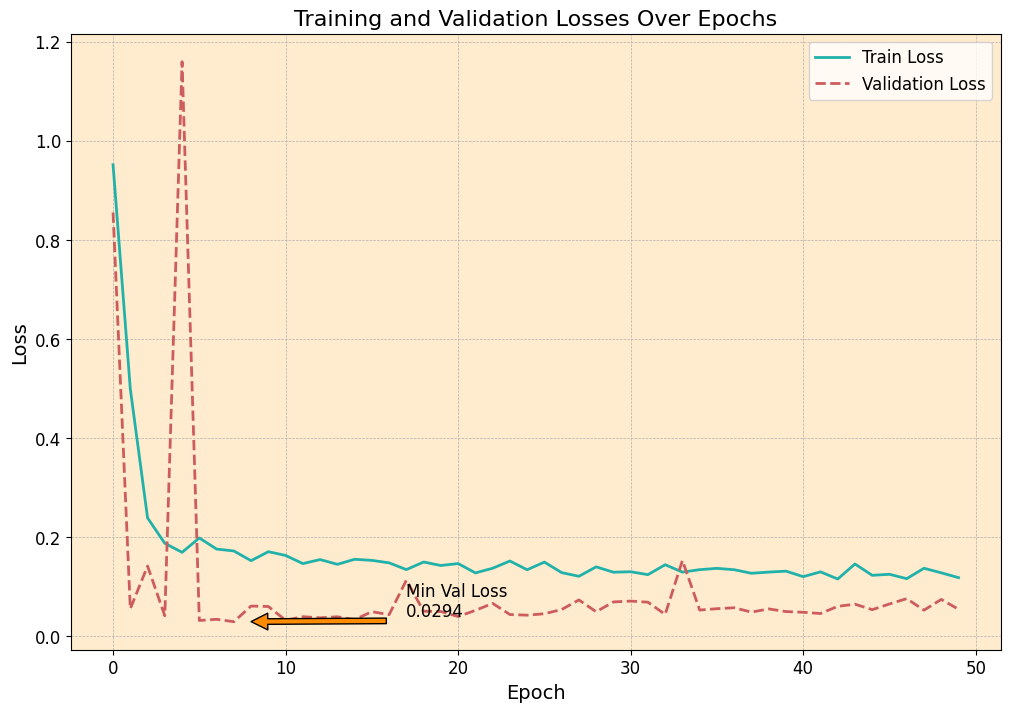

In [45]:
import matplotlib.pyplot as plt

# Plotting the losses
plt.figure(figsize=(12, 8))

# Plotting train and validation losses
plt.plot(train_losses, label='Train Loss', color='lightseagreen', linestyle='-', linewidth=2)
plt.plot(val_losses, label='Validation Loss', color='indianred', linestyle='--', linewidth=2)

# Adding titles and labels
plt.title('Training and Validation Losses Over Epochs', fontsize=16)
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Loss', fontsize=14)

# Customizing ticks
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Adding grid
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# Adding legend
plt.legend(loc='upper right', fontsize=12)

# Adding annotations for minimum validation loss
min_val_loss_epoch = val_losses.index(min(val_losses))
plt.annotate(f'Min Val Loss\n{min(val_losses):.4f}', 
             xy=(min_val_loss_epoch, min(val_losses) +0.00), 
             xytext=(min_val_loss_epoch + 10, min(val_losses) + 0.01),
             arrowprops=dict(facecolor='darkorange', shrink=0.1),
             fontsize=12, 
             color='black')

#let's add a background color to the plot
plt.gca().set_facecolor('blanchedalmond')
plt.show()




# Evaluate model on test set

In [54]:
import torch
import re
import os


def get_checkpoint_with_min_loss(directory):
    """
    Scans the given directory for checkpoint files and returns the path of the checkpoint with the minimum validation loss.

    Args:
        directory (str): The directory containing the checkpoint files.

    Returns:
        str: The path to the checkpoint with the minimum validation loss.
    """
    checkpoint_files = [f for f in os.listdir(directory) if f.startswith('model_epoch_') and f.endswith('.pth')]
    
    min_loss = float('inf')
    min_loss_checkpoint = None

    for checkpoint_file in checkpoint_files:
        # Extract the loss from the filename using regex
        match = re.search(r'model_epoch_\d+_loss_([0-9]*\.[0-9]+)\.pth', checkpoint_file)
        if match:
            loss = float(match.group(1))
            if loss < min_loss:
                min_loss = loss
                min_loss_checkpoint = os.path.join(directory, checkpoint_file)

    return min_loss_checkpoint

try:
    # Define the path to the checkpoint you want to load
    gat_Aux_dir = 'logs/model_gat_withAux/'

    # Load the checkpoint
    checkpoint_gat = torch.load(get_checkpoint_with_min_loss(gat_Aux_dir))

    # Restore the model state
    model_gatAux.load_state_dict(checkpoint_gat['model_state_dict'])

    # Retrieve additional information if needed
    epoch_gat = checkpoint_gat['epoch']
    loss_gat = checkpoint_gat['loss']


    # Set the model to evaluation mode (if you plan to use it for inference)
    model_gat.eval()

    print(f'Graph Attention Network model restored from epoch {epoch_gat} with validation loss {loss_gat:.4f}')
except FileNotFoundError:
    print('###ERROR### ----> Checkpoint not found. Probably you need to train the model first.')
except NameError:
    print('###ERROR### ----> Model not defined. Probably you need to define the model first. Just run the cell containing the model definition.')



Graph Attention Network model restored from epoch 7 with validation loss 0.0294


GraphClassificationLoss-> 0.0010099078062921762, NodeClassificationLoss-> 0.004398078192025423 on Evaluation
len(data_loader)-> 900
total_loss-> 30.361101991635223
Graph Attention Network -> Test Loss: 0.0337, Test Acc: 0.9978
Graph Attention Network -> Test Predictions: (2, 900)
Graph Attention Network -> Test Labels: (900,)
Graph Attention Network -> Test node Predictions: (900, 24)
Graph Attention Network -> Test node Labels: (900, 24)


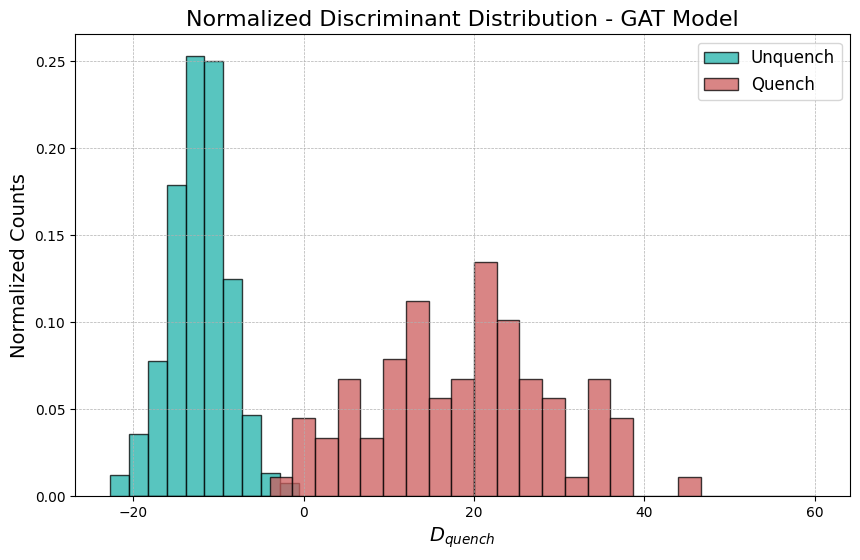

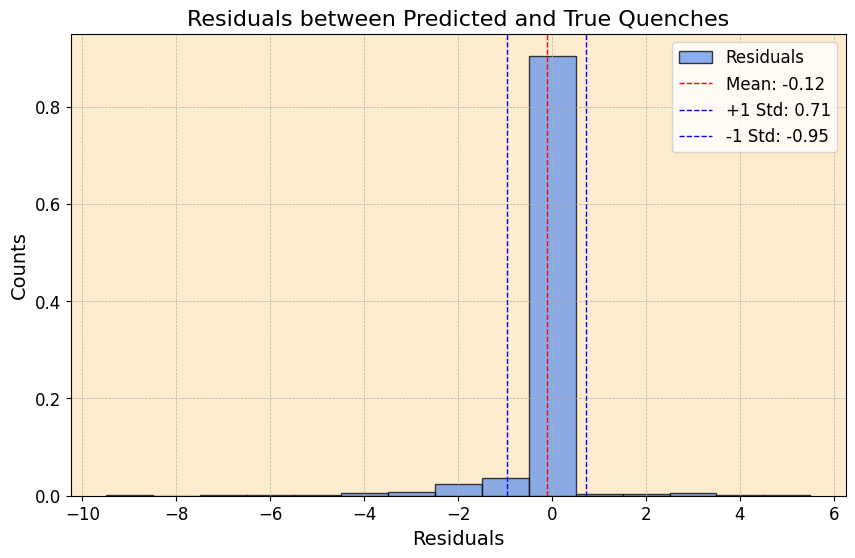

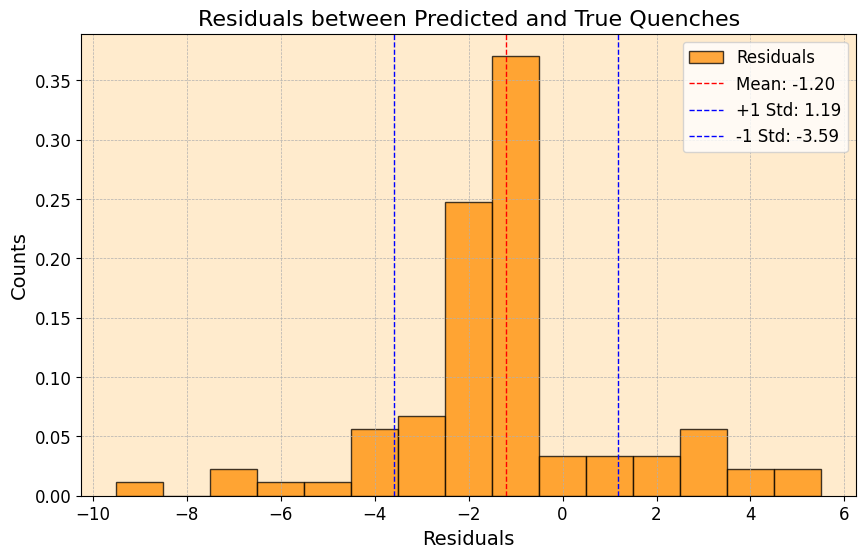

In [57]:
import numpy as np

#let's loop over the test batch and evaluate the model
test_loss_gat, test_acc_gat, predictions_test_gat, labels_test_gat, pred_nodes_test, labels_node_test = evaluate(model_gatAux, test_loader)

print(f"Graph Attention Network -> Test Loss: {test_loss_gat:.4f}, Test Acc: {test_acc_gat:.4f}")

print(f"Graph Attention Network -> Test Predictions: {predictions_test_gat.shape}")
print(f"Graph Attention Network -> Test Labels: {labels_test_gat.shape}")
print(f"Graph Attention Network -> Test node Predictions: {pred_nodes_test.shape}")
print(f"Graph Attention Network -> Test node Labels: {labels_node_test.shape}")



gatAux_Unquench_pUnquench = predictions_test_gat[0][labels_test_gat == 0]
gatAux_Unquench_pQuench = predictions_test_gat[1][labels_test_gat == 0]

gatAux_Quench_pUnquench = predictions_test_gat[0][labels_test_gat == 1]
gatAux_Quench_pQuench = predictions_test_gat[1][labels_test_gat == 1]


def Discr(pQuench,pUnquench):
    return np.log(pQuench/pUnquench)

gatAux_Unquench_Discr = Discr(gatAux_Unquench_pQuench, gatAux_Unquench_pUnquench)
gatAux_Quench_Discr = Discr(gatAux_Quench_pQuench, gatAux_Quench_pUnquench)

# Normalize the histograms
weights_unquench = np.ones_like(gatAux_Unquench_Discr) / len(gatAux_Unquench_Discr)
weights_quench = np.ones_like(gatAux_Quench_Discr) / len(gatAux_Quench_Discr)

# Plotting the normalized discriminant for the GAT model
plt.figure(figsize=(10, 6))
plt.hist(gatAux_Unquench_Discr, bins=10, weights=weights_unquench, alpha=0.75, color='lightseagreen', label='Unquench', edgecolor='black')
plt.hist(gatAux_Quench_Discr, bins=30, weights=weights_quench, alpha=0.75, color='indianred', label='Quench', edgecolor='black', range=(-20, 60))

# Adding titles and labels
plt.xlabel(r'$D_{quench}$', fontsize=14)
plt.ylabel('Normalized Counts', fontsize=14)
plt.title('Normalized Discriminant Distribution - GAT Model', fontsize=16)

# Adding legend
plt.legend(fontsize=12)

# Adding grid
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

plt.show()


import numpy as np
import matplotlib.pyplot as plt

# Funzione per confrontare le previsioni e le etichette
def compare_node_predictions(pred_nodes, labels_nodes):
    # Assicurarsi che le forme di entrambe le matrici corrispondano
    assert pred_nodes.shape == labels_nodes.shape, "Shapes of predictions and labels must match"
    
    n_quenches = np.array([])
    n_TruthQuenches = np.array([])
    for pred in pred_nodes:
        # Contare il numero di quenches
        n_quenches = np.append(n_quenches, np.sum(pred))
    for label in labels_nodes:
        # Contare il numero di quenches
        n_TruthQuenches = np.append(n_TruthQuenches, np.sum(label))
    return n_quenches, n_TruthQuenches

# Assumiamo che pred_nodes_test e labels_node_test siano definiti
n_quenches, n_TruthQuenches = compare_node_predictions(pred_nodes_test, labels_node_test)

# Calcolare i residui tra il numero di quenches previsti e il numero di quenches nella verità
residuals = n_quenches - n_TruthQuenches

# Definire un buon binning per l'istogramma
bin_width = 1
bins = np.arange(min(residuals) - 0.5, max(residuals) + 1.5, bin_width)

# Impostare il colore dello sfondo
plt.figure(figsize=(10, 6))# facecolor='blanchedalmond')
ax = plt.gca()
ax.set_facecolor('blanchedalmond')

weights = np.ones_like(residuals) / len(residuals)

# Creare l'istogramma
plt.hist(residuals, bins=bins, alpha=0.75, color='cornflowerblue', edgecolor='black', label='Residuals', weights=weights)

# Aggiungere titoli e etichette
plt.xlabel(r'Residuals', fontsize=14)
plt.ylabel('Counts', fontsize=14)
plt.title('Residuals between Predicted and True Quenches', fontsize=16)

# Aggiungere legenda
plt.legend(fontsize=12)

# Aggiungere griglia
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# Migliorare i tick dell'asse x e y
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Aggiungere annotazioni per media e deviazione standard
mean_residual = np.mean(residuals)
std_residual = np.std(residuals)
plt.axvline(mean_residual, color='red', linestyle='dashed', linewidth=1, label=f'Mean: {mean_residual:.2f}')
plt.axvline(mean_residual + std_residual, color='blue', linestyle='dashed', linewidth=1, label=f'+1 Std: {mean_residual + std_residual:.2f}')
plt.axvline(mean_residual - std_residual, color='blue', linestyle='dashed', linewidth=1, label=f'-1 Std: {mean_residual - std_residual:.2f}')
plt.legend(fontsize=12)

plt.show()


idx_truthQunches = np.where(n_TruthQuenches > 0)
#let's repeat the plot for the events with at least one quench
residuals = residuals[idx_truthQunches]
n_quenches = n_quenches[idx_truthQunches]
n_TruthQuenches = n_TruthQuenches[idx_truthQunches]

# Definire un buon binning per l'istogramma
bin_width = 1
bins = np.arange(min(residuals) - 0.5, max(residuals) + 1.5, bin_width)

# Impostare il colore dello sfondo
plt.figure(figsize=(10, 6))# facecolor='blanchedalmond')
ax = plt.gca()
ax.set_facecolor('blanchedalmond')

weights = np.ones_like(residuals) / len(residuals)

# Creare l'istogramma
plt.hist(residuals, bins=bins, alpha=0.75, color='darkorange', edgecolor='black', label='Residuals', weights=weights)

# Aggiungere titoli e etichette
plt.xlabel(r'Residuals', fontsize=14)
plt.ylabel('Counts', fontsize=14)
plt.title('Residuals between Predicted and True Quenches', fontsize=16)

# Aggiungere legenda
plt.legend(fontsize=12)

# Aggiungere griglia
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# Migliorare i tick dell'asse x e y
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Aggiungere annotazioni per media e deviazione standard
mean_residual = np.mean(residuals)
std_residual = np.std(residuals)
plt.axvline(mean_residual, color='red', linestyle='dashed', linewidth=1, label=f'Mean: {mean_residual:.2f}')
plt.axvline(mean_residual + std_residual, color='blue', linestyle='dashed', linewidth=1, label=f'+1 Std: {mean_residual + std_residual:.2f}')

plt.axvline(mean_residual - std_residual, color='blue', linestyle='dashed', linewidth=1, label=f'-1 Std: {mean_residual - std_residual:.2f}')
plt.legend(fontsize=12)

plt.show()







